# Sensitivity Analysis

The following code takes the data generated by jEplus and detemermines the influence coefficients for each parameter. It then filters out the parameters which are deemed to not have an influential effect on the chosen output. Finally, a CSV file is generated for Autotune containing all the parameters which are determined to be influential.

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

### Step 1: Initialization

First we need to define what output is being analysed. Choices are between <i>"Electricity"</i>, <i>"DistrictHeating"</i> and <i>"Water"</i>.

In [2]:
outputOfInterest = 'DistrictHeating'
#outputOfInterest = 'Electricity'
#outputOfInterest = 'Water'

We now need to load in our dataframes. Using the CSV files output from jEplus and the JSON file output from our <i>'getSensitivityIDF.ipynb'</i> script we can load in the following dataframes:
<br>
<br>
<b>parameterDF</b>: A dataframe containing all the info about the input parameters. Default values, changes in values, and job numbers which these changes occur at.
<br>
<br>
<b>SA_OutputDFs</b>: Dataframes containing results from jEplus. If there are more than one then these dataframes will need to be merged together.

In [3]:
parameterDF = pd.read_json('Building_JSON_Jobs.json').transpose().reset_index()

In [4]:
SA_OutputDF1 = pd.read_csv(f'jEplusResults\\{outputOfInterest}_Jobs1-600.csv')
SA_OutputDF2 = pd.read_csv(f'jEplusResults\\{outputOfInterest}_Jobs601-1200.csv')
SA_OutputDF3 = pd.read_csv(f'jEplusResults\\{outputOfInterest}_Jobs1201-1800.csv')
SA_OutputDF4 = pd.read_csv(f'jEplusResults\\{outputOfInterest}_Jobs1801-2400.csv')
SA_OutputDF5 = pd.read_csv(f'jEplusResults\\{outputOfInterest}_Jobs2401-3147.csv')

mergingList = [SA_OutputDF1, SA_OutputDF2, SA_OutputDF3, SA_OutputDF4, SA_OutputDF5]

SA_OutputDF = pd.concat(mergingList)

In [5]:
SA_OutputDF = SA_OutputDF[['Job_ID', outputOfInterest]]

### Step 2: Data Cleaning

jEplus results are messy and are not output in order. Therefore, we must sort these jobs in ascending order.

In [6]:
def getJobNum(row):
    return int(row['Job_ID'].split('Job')[1])

SA_OutputDF['JobNum'] = SA_OutputDF.apply(lambda row: getJobNum(row), axis=1)
SA_OutputDF = SA_OutputDF.sort_values(by='JobNum')

Ensure that no jobs are missing from our results.

In [7]:
def checkMissingValue(data, startingJobNum, finalJobNum):
    df = data.copy()
    
    missingJobNumbers = []
    i = 0
    j = startingJobNum
    while i < len(df):
    
        if df.iloc[i]['JobNum'] != j:
            missingJobNumbers.append(j)
            j = j + 1
        
        i = i + 1
        j = j + 1
        
    if len(missingJobNumbers) == 0:
        print('No jobs are missing!')
        return
    
    else:
        print(f'Jobs Missing: {missingJobNumbers}')

In [8]:
finalJobNum = SA_OutputDF['JobNum'].max()

In [9]:
checkMissingValue(SA_OutputDF, 1, finalJobNum)

No jobs are missing!


### Step 3: Create IC Dataframe

Define basecase output needed to calculate influence coefficients.

In [10]:
basecaseOutput = SA_OutputDF.iloc[0][outputOfInterest]
basecaseOutput

253296.1

Create a dataframe with all our influence coefficients.

In [11]:
jobClasses = [0]
jobObjects = [0]
jobFields = [0]
inputBasecases = [0]
inputChanges = [0]
jobNumbers = [1]

for index, row in parameterDF.iterrows():
    
    classObjectField = row['index'].split('-->')
    
    jobClasses.append(classObjectField[0])
    jobClasses.append(classObjectField[0])
    
    jobObjects.append(classObjectField[1])
    jobObjects.append(classObjectField[1])
    
    jobFields.append(classObjectField[2])
    jobFields.append(classObjectField[2])
    
    inputBasecases.append(row['Default'])
    inputBasecases.append(row['Default'])

    value1 = row['Min'] - row['Default']
    jobNumbers.append(row['MinJobNum'])
    inputChanges.append(value1)
        

    value2 = row['Max'] - row['Default']
    jobNumbers.append(row['MaxJobNum'])
    inputChanges.append(value2)

In [12]:
df1 = pd.DataFrame({'JobNum': jobNumbers, 'Class': jobClasses, 'Object': jobObjects, 'Field': jobFields,
                      'Basecase Input Value': inputBasecases, 'Input Change': inputChanges})

df2 = df1.iloc[0:finalJobNum]

IC_df = df2.merge(SA_OutputDF, on='JobNum')
IC_df['Output Change'] = IC_df[outputOfInterest] - basecaseOutput
IC_df['IC'] = (IC_df['Output Change']/basecaseOutput)/(IC_df['Input Change']/IC_df['Basecase Input Value'])
IC_df['absIC'] = abs(IC_df['IC'])

IC_df['Class'] = IC_df['Class'].astype(str)
IC_df['Object'] = IC_df['Object'].astype(str)
IC_df['Field'] = IC_df['Field'].astype(str)

IC_df['COF'] = IC_df[['Class', 'Object', 'Field']].agg('-->'.join, axis=1)

In [13]:
IC_df = IC_df[['COF', 'Class', 'Object', 'Field', 'absIC']].iloc[1:]

In [14]:
IC_df = IC_df.groupby(['COF', 'Class', 'Object', 'Field'], axis=0).sum().reset_index()

In [15]:
IC_df = IC_df.sort_values('absIC', ascending=False)

### Step 4: Examine Results

See how many input parameter IC values are above a certain cut-off point.

In [16]:
cutOff = 0.001

In [17]:
numAppropriateICs = len(IC_df.loc[IC_df['absIC'] > cutOff])

print(f'There are {numAppropriateICs} parameters above this cut off point!')

There are 453 parameters above this cut off point!


In [18]:
cumIC = IC_df['absIC'].sum()
print(f'Cumulative IC = {cumIC}')

Cumulative IC = 8.741735858121418


Determine which classes have the most effect on the chosen output.

In [19]:
IC_df.groupby(['Class'], axis=0).sum().sort_values('absIC', ascending=False)

,absIC
Class,
Site:GroundTemperature:BuildingSurface,2.429375
Material,2.123819
WindowMaterial:Glazing,1.500656
ElectricEquipment,0.720412
ZoneInfiltration:DesignFlowRate,0.564024
People,0.490941
Lights,0.430246
DesignSpecification:OutdoorAir,0.253359
WaterUse:Equipment,0.124310


Determine which objects have the most effect on the chosen output.

In [20]:
IC_df.groupby(['Object'], axis=0).sum().sort_values('absIC', ascending=False).head(25)

,absIC
Object,
Site:GroundTemperature:BuildingSurface,2.429375
2,1.500656
Cast Concrete_0.2,0.808388
Standard insulation_0.0159,0.511234
Level0:Zone32 Equipment 1,0.282541
Standard insulation_0.0096,0.265531
Level0:Zone32 Infiltration,0.221405
Cast Concrete (Dense)_0.1,0.203787
Chipboard_0.013,0.203103


Determine which fields have the most effect on the chosen output.

In [21]:
IC_df.groupby(['Field'], axis=0).sum().sort_values('absIC', ascending=False).head(25)

,absIC
Field,
Conductivity,1.237152
Design Level,0.662817
Solar Transmittance at Normal Incidence,0.631480
Design Flow Rate,0.564024
Number of People,0.428727
January Ground Temperature,0.360613
Thermal Absorptance,0.354565
Lighting Level,0.332582
December Ground Temperature,0.302087


In [22]:
IC_df = IC_df.loc[IC_df['absIC'] > cutOff]

In [23]:
IC_df

,COF,Class,Object,Field,absIC
1443,WindowMaterial:Glazing-->2-->Solar Transmittan...,WindowMaterial:Glazing,2,Solar Transmittance at Normal Incidence,0.631480
935,Material-->Standard insulation_0.0159-->Conduc...,Material,Standard insulation_0.0159,Conductivity,0.486130
887,Material-->Cast Concrete_0.2-->Conductivity,Material,Cast Concrete_0.2,Conductivity,0.390532
1322,Site:GroundTemperature:BuildingSurface-->Site:...,Site:GroundTemperature:BuildingSurface,Site:GroundTemperature:BuildingSurface,January Ground Temperature,0.360613
1320,Site:GroundTemperature:BuildingSurface-->Site:...,Site:GroundTemperature:BuildingSurface,Site:GroundTemperature:BuildingSurface,December Ground Temperature,0.302087
...,...,...,...,...,...
256,ElectricEquipment-->Level1AddedPart:Zone13 Com...,ElectricEquipment,Level1AddedPart:Zone13 Computing gain 1,Fraction Radiant,0.001024
1369,WaterUse:Equipment-->DHW Level0:Zone13-->Peak ...,WaterUse:Equipment,DHW Level0:Zone13,Peak Flow Rate,0.001021
1066,People-->People Level0:Zone49-->Number of People,People,People Level0:Zone49,Number of People,0.001013
555,Lights-->Level0:Zone53 General lighting-->Frac...,Lights,Level0:Zone53 General lighting,Fraction Radiant,0.001008


In [24]:
createICdataframe = False

if createICdataframe:
    IC_df[['COF', 'absIC']].to_csv(f'IC_DataFrames\\{outputOfInterest}_IC_DataFrame.csv', index=False)

### Step 5: Visualise Results

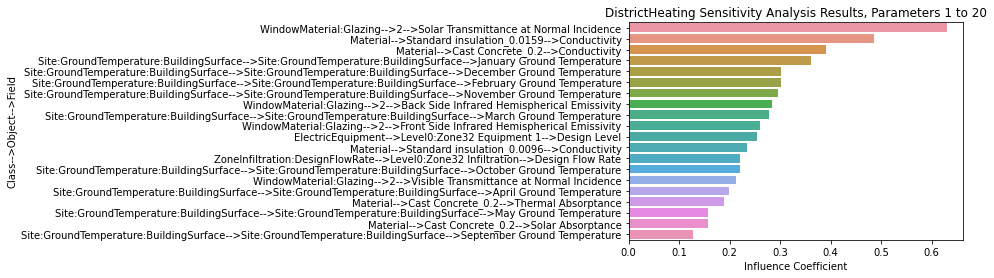

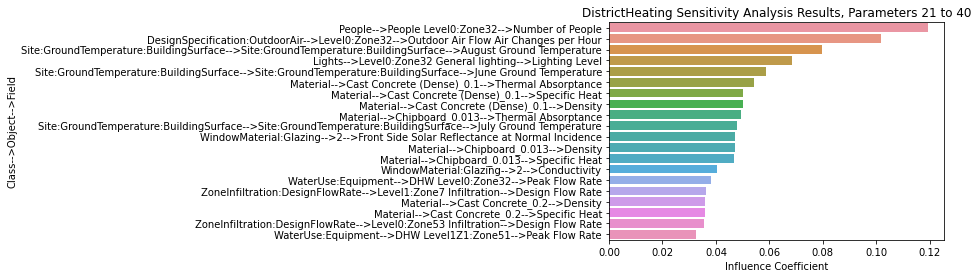

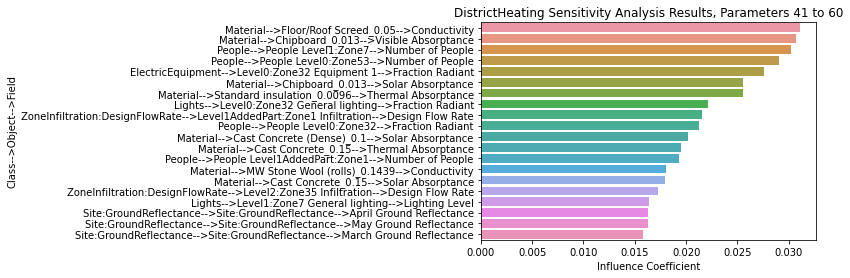

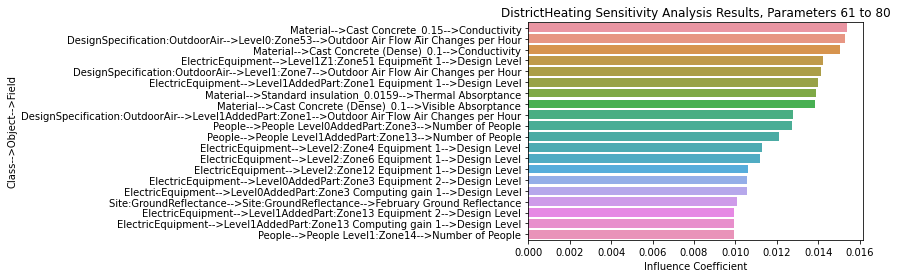

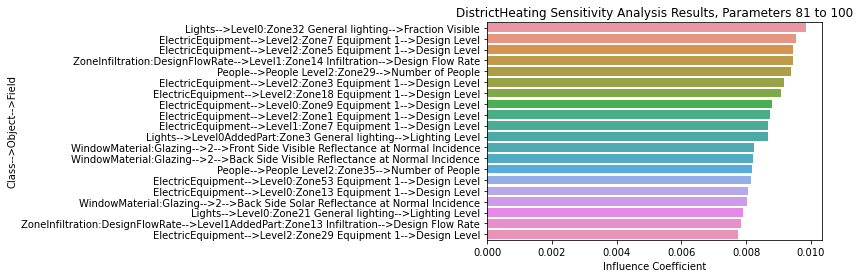

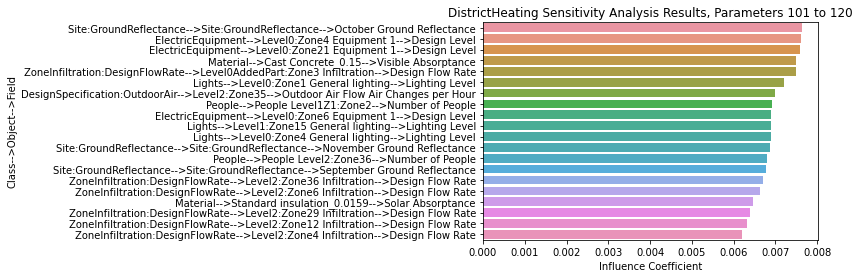

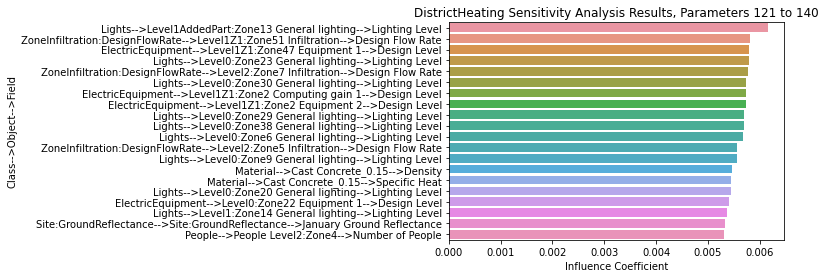

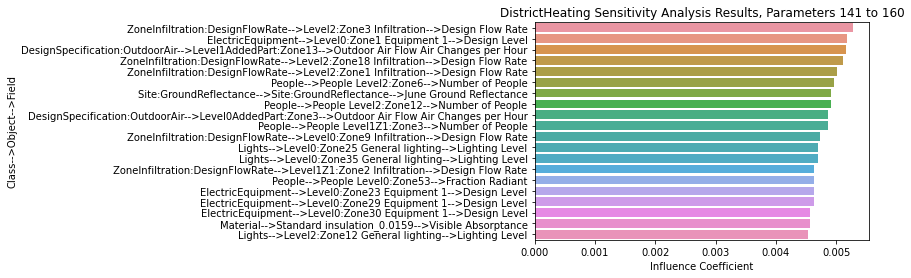

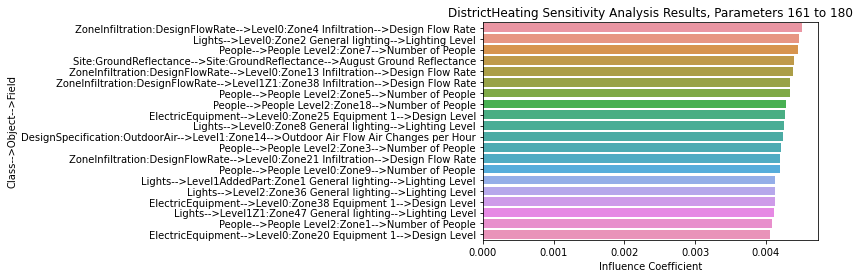

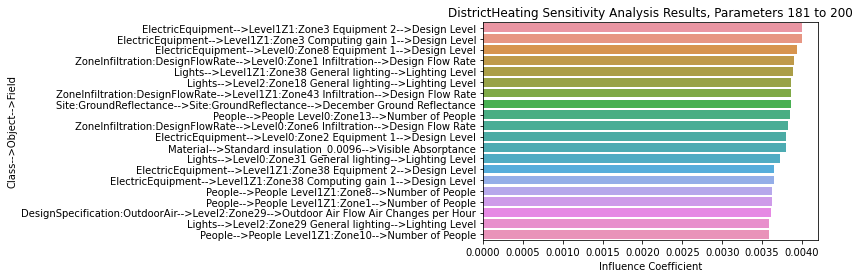

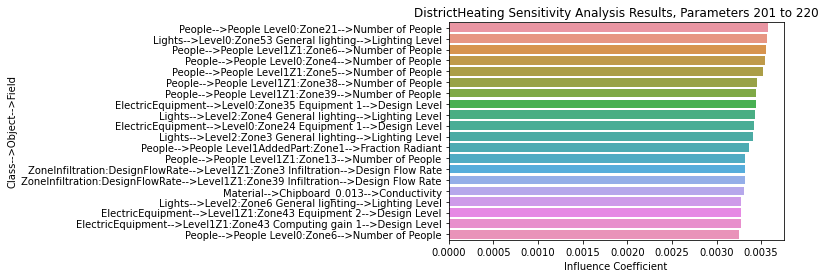

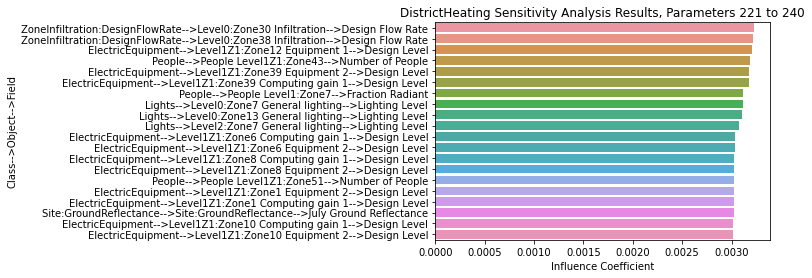

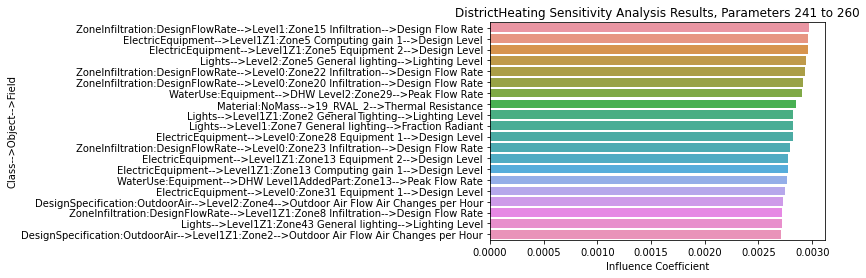

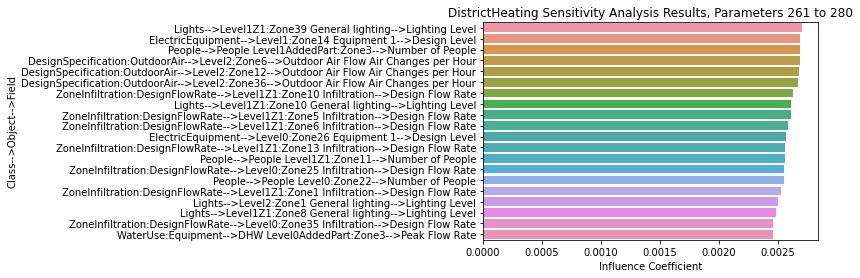

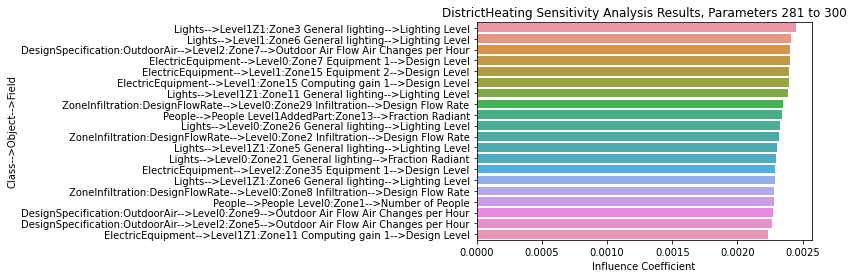

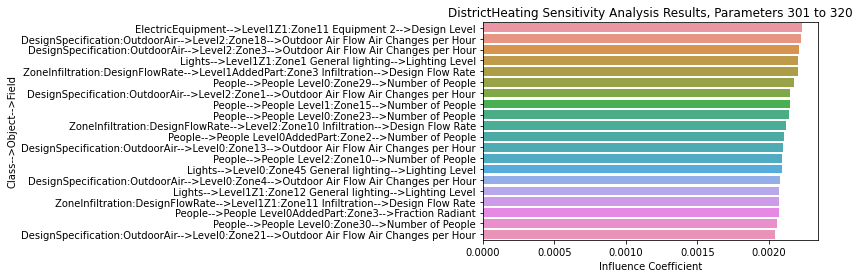

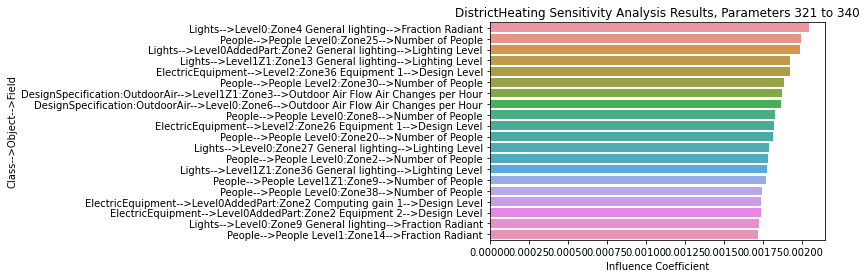

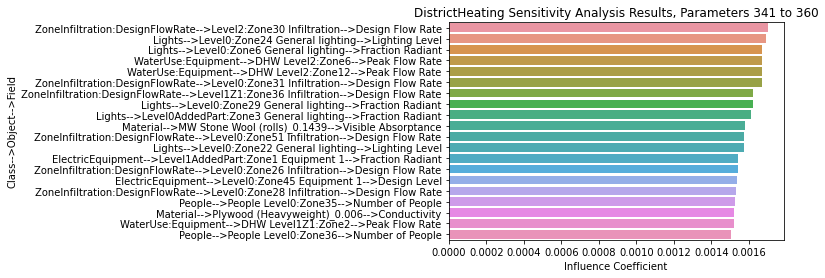

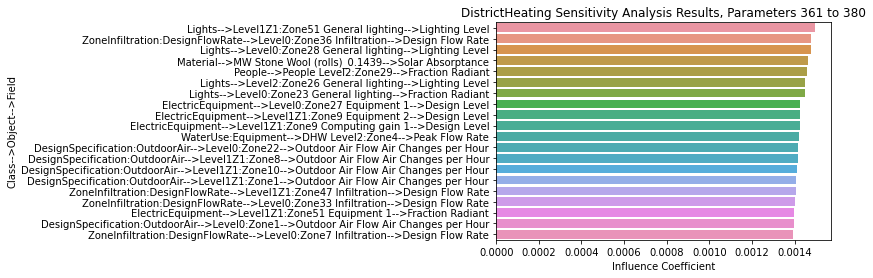

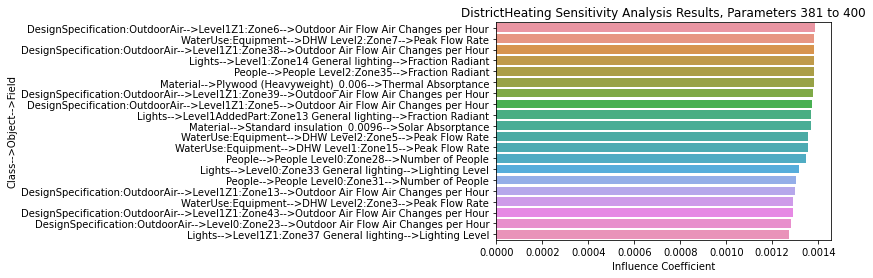

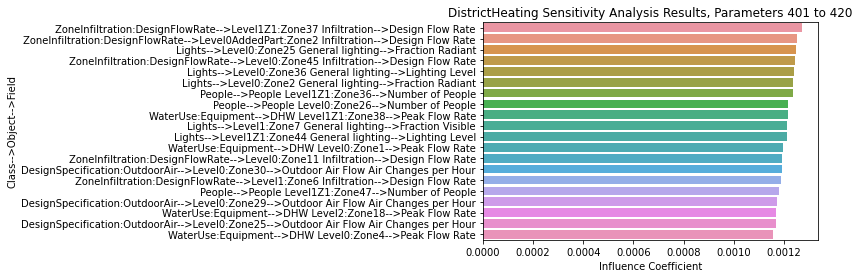

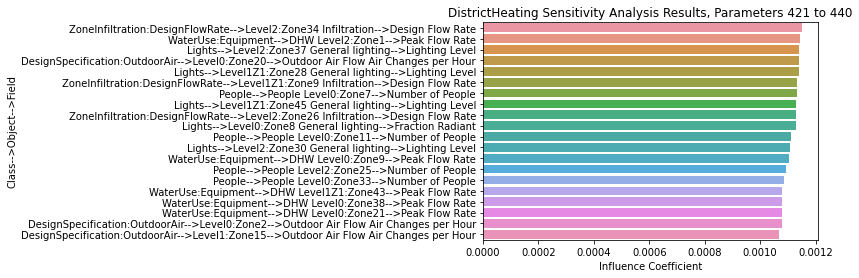

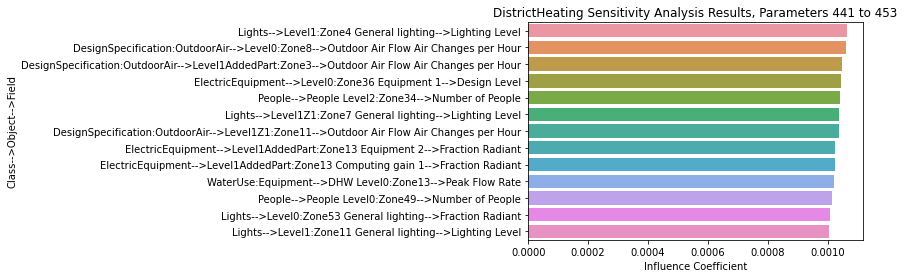

In [25]:
stepSize = 20

i = 0
while i < len(IC_df):
    data = IC_df.iloc[i:i+stepSize]
    
    if i+stepSize > len(IC_df):
        end = len(IC_df)
        
    else:
        end = i+stepSize
    
    g = sns.barplot(x=data['absIC'], y=data['COF'], ci=None)
    plt.ylabel('Class-->Object-->Field')
    plt.xlabel('Influence Coefficient')
    plt.title(f'{outputOfInterest} Sensitivity Analysis Results, Parameters {i+1} to {end}')
    plt.show()
    
    i = i + stepSize

### Step 6: Create Parameter CSV File for Autotune

In [26]:
def getClass(row):
    return row['index'].split('-->')[0]

def getObject(row):
    return row['index'].split('-->')[1]
    
def getField(row):
    return row['index'].split('-->')[2]

In [27]:
autotuneParamDF = parameterDF.copy()
autotuneParamDF['Class'] = autotuneParamDF.apply(lambda row: getClass(row), axis=1)
autotuneParamDF['Object'] = autotuneParamDF.apply(lambda row: getObject(row), axis=1)
autotuneParamDF['Field'] = autotuneParamDF.apply(lambda row: getField(row), axis=1)

In [28]:
autotuneParamDF = autotuneParamDF[['Class', 'Object', 'Field', 'Default', 'Min', 'Max']]

In [29]:
autotuneParamDF.columns = ['Class', 'Object', 'Field', 'Default', 'Minimum', 'Maximum']

In [30]:
autotuneParamDF = autotuneParamDF.loc[(autotuneParamDF['Class'].isin(list(IC_df['Class'].unique()))) &
                   (autotuneParamDF['Object'].isin(list(IC_df['Object'].unique()))) &
                   (autotuneParamDF['Field'].isin(list(IC_df['Field'].unique())))]

In [31]:
autotuneParamDF['Distribution'] = 'Uniform'
autotuneParamDF['Type'] = 'Float'

groupList = []
i = 1
while i <= len(autotuneParamDF):
    groupList.append(i)
    
    i= i + 1
    
autotuneParamDF['Group'] = groupList

In [32]:
createAutotuneParamsDF = False

if createAutotuneParamsDF:
    autotuneParamDF.to_csv(f'{outputOfInterest}_AutotuneParameters.csv', index=False)